In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size=tokenizer.vocab_size+1
print(f"vocab_size: {tokenizer.vocab_size}")
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")  

device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


vocab_size: 30522


In [2]:
from continous_diffusion import DiffusionModel

# model=DiffusionModel(embed_dim=64,
#                      qkv_dim=512,
#                      num_heads=8,
#                      cond_dim=64,
#                      n_blocks=4,
#                      vocab_size=vocab_size,
#                      device=device
#                      )

model=DiffusionModel(embed_dim=256,
                     qkv_dim=4096,
                     num_heads=8,
                     cond_dim=64,
                     n_blocks=32,
                     vocab_size=vocab_size,
                     device=device
                     )

print(f"n parameters:{model.n_parameters/1e6}M")
# model.load_state_dict(torch.load('checkpoints/1.pt'))

n parameters:139.96048M


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=64, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-3)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR
milestone=20
warmup=LinearLR(optimizer,1e-3,1,milestone)
decay=ExponentialLR(optimizer,gamma=0.97)
lr_scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[milestone+1])

In [4]:
for i in train_loader:
    print(tokenizer.batch_decode(i['input_ids']))
    break

['[CLS] one day, tom and his dog spot went to the park. they liked to play and run on the grass. spot had soft fur and a wet nose. tom liked to hug him and pet him. " spot, you are my best friend, " tom said. " do you want a treat? " [SEP]', '[CLS] once upon a time there was a little boy. he wanted to go outside and play but the door was too thick. he put his hands on the door and tried to turn it, but it wouldn\'t move. he shouted to his mum, " mum, i can\'t turn the door! " [SEP]', "[CLS] once upon a time, there was a little girl who wanted to live in a fancy bedroom. she asked her mom for it, but her mom just shrugged. so the girl wasn't happy and started pouting. she decided that if her mom wouldn't give her a nice bedroom, she'd [SEP]", '[CLS] once upon a time, there was a chubby little girl named lily who lived next door to a friendly neighbor named mrs. brown. one day, lily was playing with her toys outside when she saw mrs. brown walking by with a big bag of groceries. " hi mrs

lr: 7.609382285602576e-06


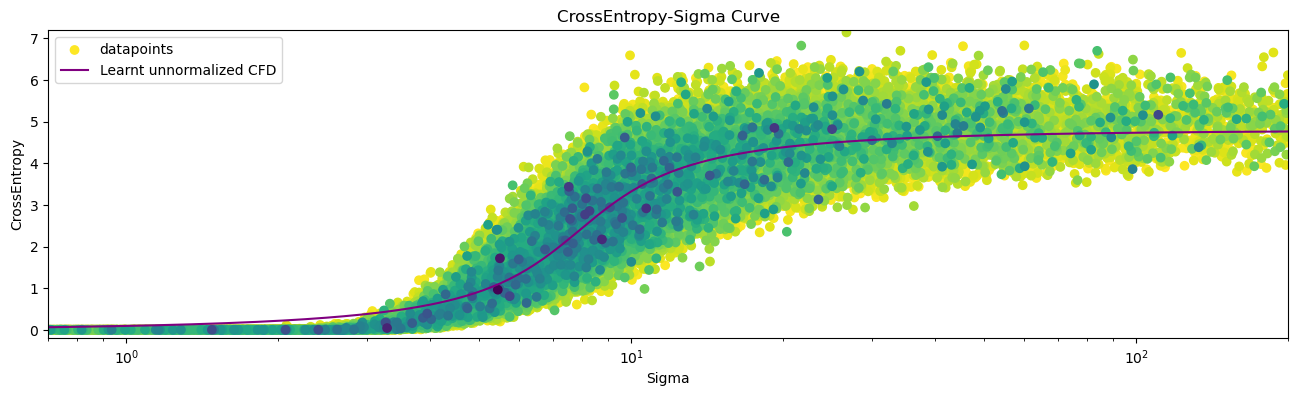

KeyboardInterrupt: 

In [5]:
schedule_update_frequency=500
plotting_frequency=100

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%plotting_frequency==0 or i%schedule_update_frequency==0:
            clear_output(wait=True) 

        if i%schedule_update_frequency==0 and i!=0:
            model.noise_schedule.update_optimal_parameters()
            model.noise_schedule.plot_training_curves(
                f'CrossEntropy-Sigma Curve for {(model.n_parameters/1e6):.2f}M parameters every {schedule_update_frequency} batches'
                )
            
        if i%plotting_frequency==0 and i!=0:
            lr_scheduler.step()
            print(f"lr: {lr_scheduler.get_last_lr()[0]}")
            model.noise_schedule.plot_entropy_time_curve()

In [6]:
out_embeddings=model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:22<00:00, 44.42it/s]


In [7]:
from torch.distributions.categorical import Categorical

logits=model.un_embedder(out_embeddings)

distrubution=Categorical(logits=logits)
sample=distrubution.sample()

# sample=logits.argmax(dim=-1)

tokenizer.batch_decode(sample)

['vanished mum white david fun sweet lived ropepop biased her billy small yoτ she apron by boat dropped surge sky. cups old withooped outside paper - dennis chilly careful books cage wrapping next place to hole max picked bouncing thatuce jet smell with balloon she. candle argentina sink look! attested quinn underneath pill car have sawdos']

In [9]:
model.noise_schedule.optimal_parameters

Parameter containing:
tensor([ 7.3022,  3.0190,  5.4781, -0.6862])

In [8]:
torch.save(model.state_dict(),f'checkpoints/{(model.n_parameters/1e6):.2f}M_parameters.pt')